### This is a Wavelet script that actually works, huzzah!

In [2]:
import pandas as pd
import numpy as np
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import sklearn

# Discrete Wavelet Transform
import pywt

pd.set_option('display.width',500)
#get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline
!pwd
print (np.__version__)
print (pd.__version__)

# Global Variables
CSV = "Azure_Temps_To_July2019.csv"

/Users/kirstin.Aschbacher@ouraring.com/Desktop/azure/Wavelets_Oura_iButtons
1.18.1
1.0.1


In [3]:
%%time
def load_data(data_path: str) -> pd.DataFrame:
    df = pd.read_csv(data_path, sep=';', encoding='utf-8', header=0, parse_dates=['Local Date', 'Local Time'])
    df.rename(columns={'Skin temperature':'temperature', 'Unix time':'unix_time'}, inplace=True)
    df.sort_values(by='unix_time', inplace=True, ascending=True)
    return df

df = load_data(CSV)
print (df.shape)
df.head(3)

(257310, 7)
CPU times: user 9.7 s, sys: 69.8 ms, total: 9.77 s
Wall time: 9.8 s


,unix_time,Timezone Offset,Local Date,Local Time,temperature,ACM Temperature,CPU Temperature
0,1551497700,-480,2019-01-03,2020-06-29 19:35:00,3593.0,3191.0,3076.0
1,1551497760,-480,2019-01-03,2020-06-29 19:36:00,3570.0,3179.0,3010.0
2,1551497820,-480,2019-01-03,2020-06-29 19:37:00,3538.0,3159.0,2975.0


In [4]:
def build_short_df(df: pd.DataFrame, n_days: int) -> pd.DataFrame:
    """Let's make a dataframe only X Days Long"""
    s_day = 60*24# samples per day
    n_days = 5# number of days to visualize
    short_df = df.iloc[:n_days*s_day, :].copy().dropna()
    return short_df

short_df = build_short_df(df=df, n_days=5)
print (short_df.shape)

(7196, 7)


In [5]:
sampling_period = 1/60# time difference btw two consecutive samples; inverse of sampling frequency
dt = sampling_period#  e.g., 100 Hz sampling.  1 sample per second --> 1 Hz
wavelet = 'cmor1.5-1.0'
scales = range(1,1440)#[60, 120, 360, 720, 1440]# Reasonable choices?  Does 1440 correspond to the daily rhythm?
signal = 'temperature'

# This function converts from scale domain to frequency domain. Higher scale is lower frequency
f = pywt.scale2frequency(wavelet, scales)/sampling_period# f is hertz when sampling_period in seconds
print ('Frequencies: {}\n'.format(f))
print ('Nyquist limit = {}\n'.format(dt/4))# Per conversation with Adam Rao

Frequencies: [6.00000000e+01 3.00000000e+01 2.00000000e+01 ... 4.17536534e-02
 4.17246175e-02 4.16956220e-02]

Nyquist limit = 0.004166666666666667



### This part makes my CPU blow up

In [6]:
# coeff, freq = pywt.cwt(df[signal], scales, wavelet, dt)
# print (len(coeff[0]), len(freq)) 
# power = abs(coeff)**2
# power[:5]

### Using Ahmet's Wavelet Code
http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

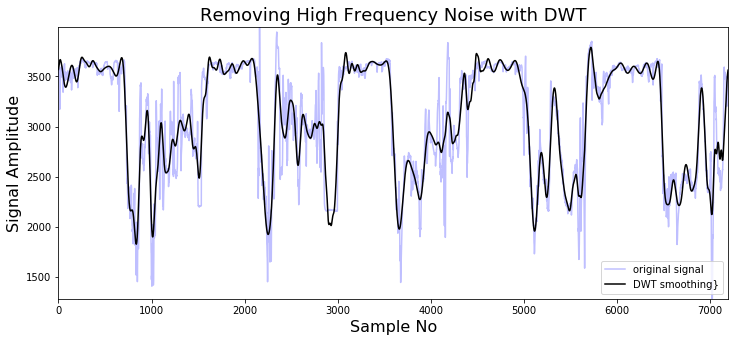

In [9]:
def plot_wavelet_denoised(df, signal):

    def lowpassfilter(signal, thresh, wavelet="db32"):
        thresh = thresh*np.nanmax(signal)
        coeff = pywt.wavedec(signal, wavelet, mode="per" )
        coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
        reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
        return reconstructed_signal

    # Original signal
    xrange = list(range(df.shape[0]))
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(xrange, df[signal], color="b", alpha=0.25, label='original signal')

    # Smoothing with Discrete Wavelet Transform
    rec = lowpassfilter(df[signal], .40)
    rec = rec[:df.shape[0]]# sometimes the DWT returns a vector one longer than the original signal
    ax.plot(xrange, rec, 'k', label='DWT smoothing}', linewidth=1.5)

    ax.legend()
    ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
    ax.set_ylabel('Signal Amplitude', fontsize=16)
    ax.set_xlabel('Sample No', fontsize=16)
    plt.margins(0)
    plt.show()
    return rec

rec = plot_wavelet_denoised(short_df, signal)

### And using this nice scalogram plotter kirstin found
https://dsp.stackexchange.com/questions/62612/plotting-a-scalogram-of-a-signals-continuous-wavelet-transform-cwt-in-python#https://dsp.stackexchange.com/questions/62612/plotting-a-scalogram-of-a-signals-continuous-wavelet-transform-cwt-in-python

In [10]:
def plot_wavelet(ax, time2, signal, scales, waveletname = 'cmor', 
                 cmap =plt.cm.seismic, title = 'Scalogram', ylabel = '', xlabel = ''):
    dt=time2
    coefficients, frequencies = pywt.cwt(signal, scales, waveletname, dt)

    power = (abs(coefficients)) ** 2
    period = frequencies
    #levels = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1]
    levels = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5 , 1.  , 2]
    contourlevels = np.log2(levels) #original
    time=range(signal.size)# MIGHT CHANGE THIS - len(signal)

    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both', cmap=cmap)


    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))    
    ax.set_yticks(np.log2(yticks)) #original
    ax.set_yticklabels(yticks) #original
    ax.invert_yaxis()
    ylim = ax.get_ylim()

    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")

    return yticks, ylim

In [11]:
def normalize(df, signal):
    # Normalize - Azure doesn't get what the '_z' is --> z-score formula is a way to normalize
    s_norm = signal+'_z'
    df[s_norm] = (df[signal] - df[signal].mean()) / df[signal].std()
    return df

# Alternately zscore
#s = df[s_norm].iloc[1440*60:1440*67].dropna()
df = normalize(df, signal)

(array([0.125, 0.25 , 0.5  , 1.   , 2.   ]), (1.584962500721156, -3.0))

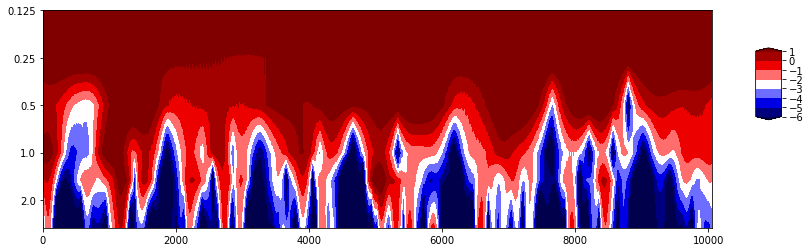

In [12]:
# iloc is Purely integer-location based indexing for selection by position.
# .rolling provides rolling window calculations. for temp data we don't want to 
#roll by any frequency that would obliterate anything > 60 min so I've dropped this to 5
#quantile returns only the data within the given decimal specified quantile
#dropna drops rows containing missing values. Not sure what it replaces them with
#hopefully an average value of surrounding data but I need to check

# Voila; wavelet below

s_norm = signal+'_z'
s = df[s_norm].iloc[1440*60:1440*67].rolling(5).quantile(.95).dropna()

scales = [60, 120, 180, 360, 720, 1440]

fig, ax = plt.subplots(figsize=(12,4))
plot_wavelet(ax, 1/60, s, scales, waveletname = 'cmor1.5-3.0', 
                 cmap =plt.cm.seismic, title = '', ylabel = '', xlabel = '')